In [104]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.fft import fft, fftfreq
import pandas as pd
import csv


In [105]:

# Load the audio file
sample_rate, data = wav.read('samples/c5.wav')

# If stereo, convert to mono by averaging the channels
if data.ndim > 1:
    data = data.mean(axis=1)

In [106]:
def plot_waveform_and_spectrum(time, waveform, xf, yf):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 0.7]})

    # Waveform plot
    waveform_every_n = 1  # Plot every n-th sample to prevent clutter
    ax1.plot(time[::waveform_every_n], waveform[::waveform_every_n], color='#1f77b4', linewidth=1.2)
    ax1.set_title('Waveform', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.5)

    # Frequency Spectrum plot (Magnitude only)
    ax2.plot(xf[:n // 2], np.abs(yf[:n // 2]) / n, color='#ff7f0e', linewidth=1.2)
    ax2.set_title('Frequency Spectrum', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Frequency (Hz)', fontsize=12)
    ax2.set_ylabel('Magnitude', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)
    ax2.set_xlim(0, sample_rate / 2)  # Only show positive frequencies

    # Aesthetic adjustments
    plt.subplots_adjust(hspace=0.4)
    fig.suptitle('Waveform and Frequency Spectrum Analysis', fontsize=18, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plt.show()

In [107]:
# Time array for the waveform plot
time = np.linspace(0, len(data) / sample_rate, num=len(data))

# Number of samples in the audio file
n = len(data)
duration = n / sample_rate

# Perform the FFT
yf = fft(data)
xf = fftfreq(n, 1 / sample_rate)

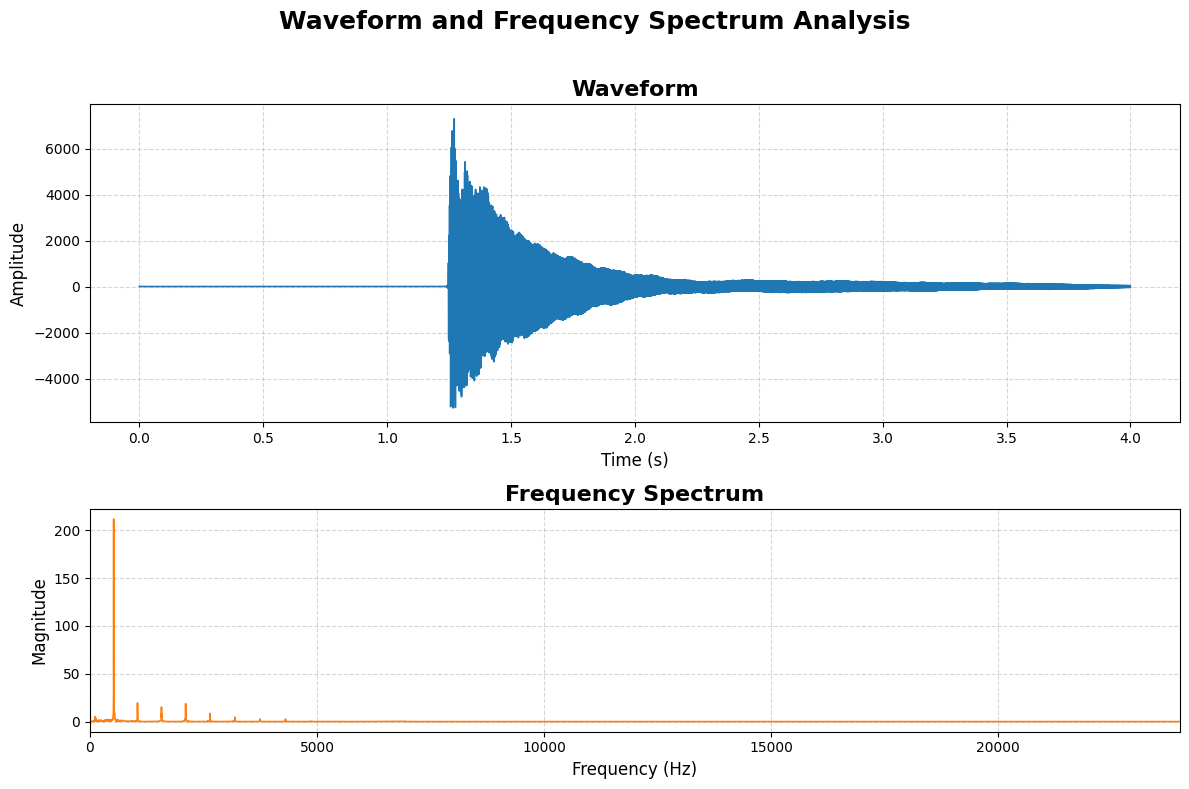

In [108]:
plot_waveform_and_spectrum(time, data, xf, yf)

In [109]:
with open('c5_frequencies_amplitudes.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Frequency (Hz)', 'Amplitude'])
    for i in range(n // 2):
        writer.writerow([xf[i], np.abs(yf[i]) / n])

In [115]:
data = pd.read_csv('c5_frequencies_amplitudes.csv')

# Parameters for analysis
amplitude_threshold = 0.5 * data['Amplitude'].max()  # Set a threshold to filter out noise

# Filter out frequencies below the amplitude threshold
significant_frequencies = data[data['Amplitude'] > amplitude_threshold]

# Sort by amplitude in descending order to get the most prominent frequencies
significant_frequencies = significant_frequencies.sort_values(by='Amplitude', ascending=False)
print(f"Number of significant frequencies: {len(significant_frequencies)}")

# Extract prominent frequencies and their amplitudes
prominent_frequencies = []
for _, row in significant_frequencies.iterrows():
    prominent_frequencies.append((row['Frequency (Hz)'], row['Amplitude']))

# Print the most prominent frequencies
print("Prominent frequencies:")
for freq, amp in prominent_frequencies:
    print(f"Frequency: {freq:.2f} Hz, Amplitude: {amp:.2f}")

# make every frequency relative to 523.25 Hz and the amplitute range from 0 to 1
prominent_frequencies_relative = []
for freq, amp in prominent_frequencies:
    prominent_frequencies_relative.append((freq/523.25, amp/np.max(data['Amplitude'])))
print("Prominent frequencies relative to 523.25 Hz and amplitudes normalized to 0-1:")

# Export to a CSV for further analysis or use in synthesis
with open('piano_overtones.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Frequency (Hz)', 'Amplitude'])
    for freq, amp in prominent_frequencies_relative:
        writer.writerow([freq, amp])

print("Filtered CSV file 'c5_prominent_frequencies_amplitudes.csv' has been created.")

Number of significant frequencies: 6
Prominent frequencies:
Frequency: 523.25 Hz, Amplitude: 211.63
Frequency: 523.00 Hz, Amplitude: 172.37
Frequency: 523.75 Hz, Amplitude: 162.81
Frequency: 523.50 Hz, Amplitude: 150.52
Frequency: 524.00 Hz, Amplitude: 124.91
Frequency: 522.75 Hz, Amplitude: 122.49
Prominent frequencies relative to 523.25 Hz and amplitudes normalized to 0-1:
Filtered CSV file 'c5_prominent_frequencies_amplitudes.csv' has been created.


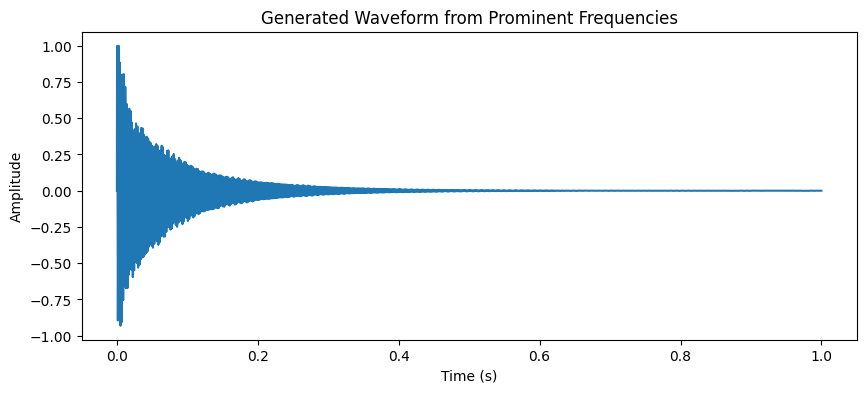

Generated tone saved as 'generated_c5_tone.wav'


In [116]:
from scipy.io.wavfile import write

# Load the CSV data with prominent frequencies and amplitudes
data = pd.read_csv('c5_prominent_frequencies_amplitudes.csv')

# Synthesis parameters
sample_rate = 44100  # Samples per second
duration = 2.0       # Duration of the generated tone in seconds
time = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Initialize an empty waveform
waveform = np.zeros_like(time)

# Generate the waveform by summing sine waves for each prominent frequency
for _, row in data.iterrows():
    frequency = row['Frequency (Hz)']
    amplitude = row['Amplitude']

    # Generate sine wave for the current frequency
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * time) * np.exp(-0.00015 * 2 * np.pi * frequency * time * 10)  # Exponential decay

    # Add the sine wave to the waveform
    waveform += sine_wave

# Normalize the waveform to prevent clipping
waveform = waveform / np.max(np.abs(waveform))

# Plot the generated waveform
plt.figure(figsize=(10, 4))
plt.plot(time[:44100], waveform[:44100])  # Plot the first 1000 samples for clarity
plt.title('Generated Waveform from Prominent Frequencies')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Save the generated waveform as a .wav file
output_file = 'generated_c5_tone.wav'
write(output_file, sample_rate, (waveform * 32767).astype(np.int16))  # Convert to 16-bit PCM format

print(f"Generated tone saved as '{output_file}'")
